In [5]:
import io
import netCDF4
import numpy
import matplotlib.pyplot as plt
import os
import sys
import xarray as xr

In [10]:
# path to ocean_annual file
path_year = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/Redi_test_const/23000101.ocean_annual.nc'
dy = xr.open_dataset(path_year, decode_times=True)

outdir = 'Redi_test_const/FIGURES/'

suptitle = 'Redi Test (constant forcing)'   # Super-title for experiment.  Default is to read from netCDF file.


In [152]:
def linCI(min, max, ci, *args):
  """
  Returns list of linearly spaced contour intervals from min to max with spacing ci.
  Unline numpy.arange this max is included IF max = min + ci*N for an integer N.
  """
  if len(args): return numpy.concatenate( (numpy.arange(min, max+ci, ci), linCI(*args)) )
  return numpy.arange(min, max+ci, ci)


def pmCI(min, max, ci, *args):
  """
  Returns list of linearly spaced contour intervals from -max to -min then min to max with spacing ci.
  Unline numpy.arange this max is included IF max = min + ci*N for an integer N.
  """
  ci = linCI(min, max, ci, *args)
  if ci[0]>0: return numpy.concatenate( (-ci[::-1],ci) )
  else: return numpy.concatenate( (-ci[::-1],ci[1:]) )


def MOCpsi(vh, vmsk=None):
    """Sums 'vh' zonally and cumulatively in the vertical to yield an overturning stream function, psi(y,z)."""
    shape = list(vh.shape); shape[-3] += 1
    psi = numpy.zeros(shape[:-1])
    if len(shape)==3:
      for k in range(shape[-3]-1,0,-1):
        if vmsk is None: psi[k-1,:] = psi[k,:] - vh[k-1].sum(axis=-1)
        else: psi[k-1,:] = psi[k,:] - (vmsk*vh[k-1]).sum(axis=-1)
    else:
      for n in range(shape[0]):
        for k in range(shape[-3]-1,0,-1):
          if vmsk is None: psi[n,k-1,:] = psi[n,k,:] - vh[n,k-1].sum(axis=-1)
          else: psi[n,k-1,:] = psi[n,k,:] - (vmsk*vh[n,k-1]).sum(axis=-1)
    return psi
  
def plotPsi(y, z, psi, ci, title):
    cmap = plt.get_cmap('RdBu_r')
    plt.contourf(y, z, psi, levels=ci, cmap=cmap, extend='both')
    cbar = plt.colorbar()
    plt.contour(y, z, psi, levels=ci, colors='k')
#     plt.gca().set_yscale('splitscale',zval=[0.,-2000.,-6500.])
    plt.gca().invert_yaxis()
    plt.gca().set_xlim([-70,70])
    plt.title(title, fontsize=14)
    cbar.set_label('[Sv]', fontsize=14)
    plt.ylabel('Elevation [m]', fontsize=14); plt.xlabel(r'Latitude [$\degree$N]', fontsize=14)
    return


def findExtrema(y, z, psi, min_lat=-90., max_lat=90., min_depth=0., mult=1.):
    psiMax = mult*numpy.amax( mult * numpy.ma.array(psi)[(y>=min_lat) & (y<=max_lat) & (z<-min_depth)] )
    idx = numpy.argmin(numpy.abs(psi-psiMax))
    (j,i) = numpy.unravel_index(idx, psi.shape)
    plt.plot(y[j,i],z[j,i],'kx',hold=True)
    plt.text(y[j,i],z[j,i],'%.1f'%(psi[j,i]))
    return

def heatTrans(advective, diffusive=None, lbd=None, vmask=None):
    """Converts vertically integrated temperature advection into heat transport"""
    HT = advective[:]
    if diffusive is not None:
        HT = HT + diffusive[:]
    if lbd is not None:
        HT = HT + lbd[:]
    if len(HT.shape) == 3:
        HT = HT.mean(axis=0)
#   if advective.units == "Celsius meter3 second-1":
#     rho0 = 1.035e3
#     Cp = 3992.
#     HT = HT * (rho0 * Cp)
    HT = HT * 1.e-15  # convert to PW
#   elif advective.units == "W":
#     HT = HT * 1.e-15
#   else:
#     print('Unknown units')
    if vmask is not None: HT = HT*vmask
    HT = HT.sum(axis=-1); HT = HT.squeeze() # sum in x-direction
    return HT


def plotHeatTrans(y, HT, title, xlim=(-70,70), ylim=(-2.5,3.0)):
    plt.plot(y, y*0., 'k', linewidth=0.5)
    plt.plot(y, HT, 'r', linewidth=1.5, label='Model')
    plt.xlim(xlim); plt.ylim(ylim)
    plt.title(title)
    plt.grid(True)



In [111]:
VHmod = dy.vmo.mean(dim='time')
conversion_factor = 1.e-9

zl = dy.zl
y = dy.yq
x = dy.xh

x_west = numpy.where(dy['xh']==211)[0][0]
x_east = numpy.where(dy['xh']==351)[0][0]

/home/sragen/.conda/envs/aqua/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


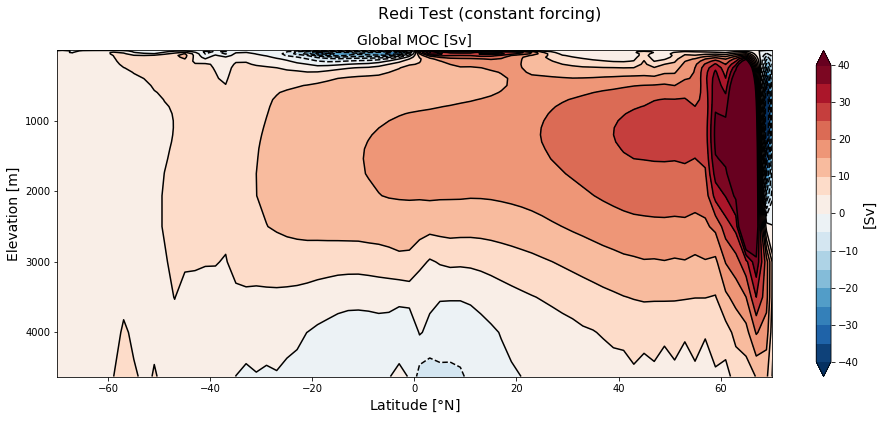

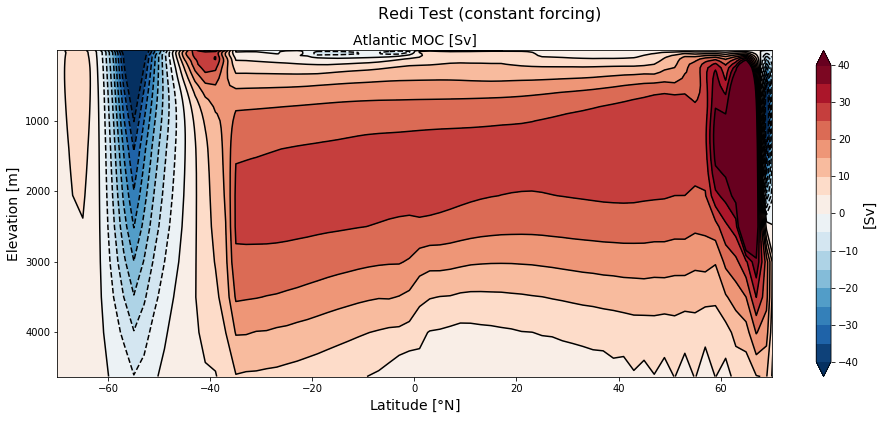

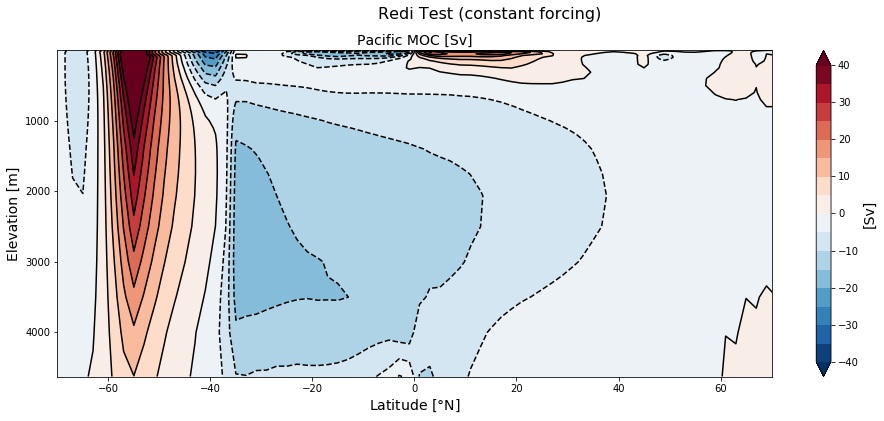

In [112]:
# Global MOC
plt.subplots(figsize=(16,6))
axis = plt.gca()
psiPlot = MOCpsi(VHmod)*conversion_factor
ci=pmCI(0.,40.,5.)
plotPsi(y, zl, psiPlot[:-1,:], ci, 'Global MOC [Sv]')
plt.suptitle(suptitle, fontsize=16)
objOut = outdir+'/MOC_global.png'
plt.savefig(objOut)

# Atlantic MOC
plt.subplots(figsize=(16,6))
ci=pmCI(0.,40.,5.)
psiPlot = MOCpsi(VHmod.isel(xh=slice(x_west,x_east)))*conversion_factor
plotPsi(y, zl, psiPlot[:-1,:], ci, 'Atlantic MOC [Sv]')
plt.suptitle(suptitle, fontsize=16)
objOut = outdir+'/MOC_Atlantic.png'
plt.savefig(objOut,format='png')

# Atlantic MOC
plt.subplots(figsize=(16,6))
ci=pmCI(0.,40.,5.)
psiPlot = MOCpsi(VHmod.isel(xh=slice(0,x_west)))*conversion_factor
plotPsi(y, zl, psiPlot[:-1,:], ci, 'Pacific MOC [Sv]')
plt.suptitle(suptitle, fontsize=16)
objOut = outdir+'/MOC_Pacific.png'
plt.savefig(objOut,format='png')

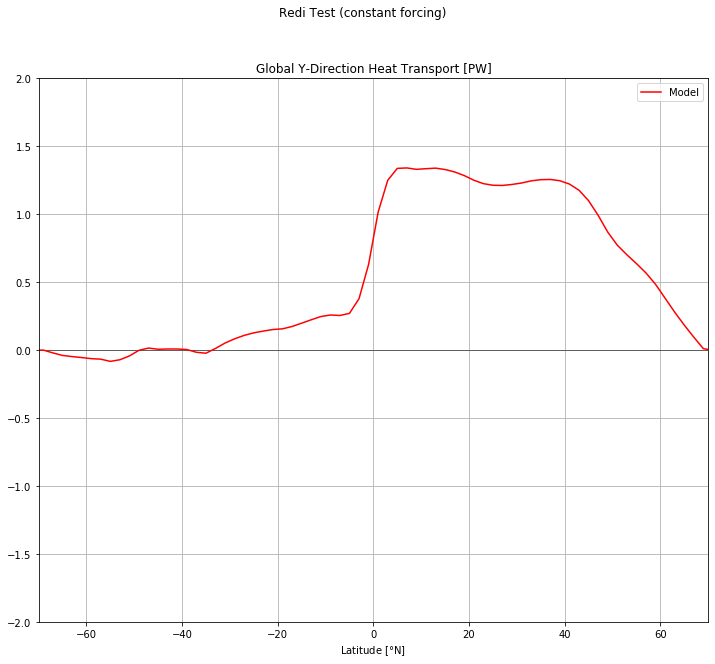

In [154]:
# Global Heat Transport
plt.figure(figsize=(12,10))
HTplot = heatTrans(dm.T_ady_2d.isel(time=slice(-361,-1)).mean(dim='time'), 
                   dm.T_diffy_2d.isel(time=slice(-361,-1)).mean(dim='time'))
plotHeatTrans(y, HTplot,title='Global Y-Direction Heat Transport [PW]', ylim=(-2.,2.))
# plt.plot(yobs,NCEP['Global'],'k--',linewidth=0.5,label='NCEP')
# plt.plot(yobs,ECMWF['Global'],'k.',linewidth=0.5,label='ECMWF')
# plotGandW(GandW['Global']['lat'],GandW['Global']['trans'],GandW['Global']['err'])
plt.xlabel(r'Latitude [$\degree$N]',fontsize=10)
plt.suptitle(suptitle)
plt.legend(loc=0,fontsize=10)
# annotateObs()
# if diffusive is None: annotatePlot('Warning: Diffusive component of transport is missing.')
# if lbd is None: annotatePlot('Warning: LBD component of transport is missing.')

objOut = outdir+'/HeatTransport_global.png'
plt.savefig(objOut)
plt.show()

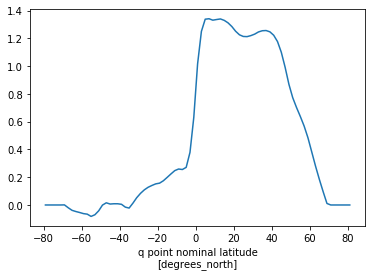

In [150]:
HT = (dm.T_ady_2d.isel(time=slice(-361,-1)).mean(dim='time').sum(dim='xh') 
      + dm.T_diffy_2d.isel(time=slice(-361,-1)).mean(dim='time').sum(dim='xh'))

if len(HT.shape) == 3:
    HT = HT.mean(axis=0)
    
HT = HT * 1.e-15 

HT.plot()

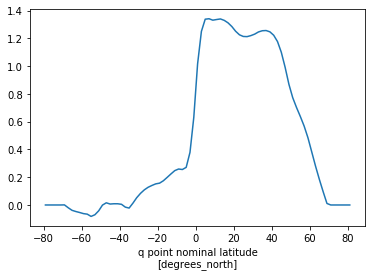

In [147]:
HT = (dm.T_ady_2d.isel(time=slice(-361,-1)).mean(dim='time')
      + dm.T_diffy_2d.isel(time=slice(-361,-1)).mean(dim='time'))

if len(HT.shape) == 3:
    HT = HT.mean(axis=0)
    
HT = HT * 1.e-15 

HT = HT.sum(axis=-1)

HT.plot()

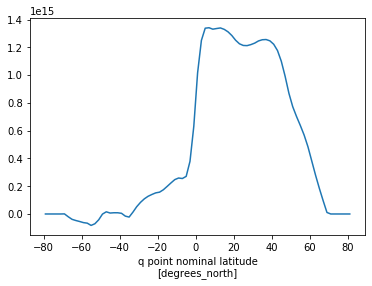

In [151]:
HTplot.plot()